In [309]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [310]:
import pandas as pd
import numpy as np
import tensorflow as tf
import string
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

In [311]:
lines = open('drive/My Drive/hamdan/data.txt','r',encoding='utf=8').readlines()

In [312]:
lines.append('\n')

In [313]:
ids=[]
urls=[]
labels=[]
texts=[]
orders=[]
total_lines=[]
id=-1
url=''
order = 0
for line in lines:
    if line[0]=='#':
        id= int(line[line.index('[')+1: line.index(']')])
        url= line[line.index(']')+1:]
        order =0
    elif line != '\n':
        tokens = line.split('\t')
        labels.append(tokens[0])
        text = tokens[1].lower().translate(str.maketrans('', '', string.punctuation))
        texts.append(text)
        orders.append(order)
        order=order+1
        ids.append(id)
        urls.append(url)
    elif line =='\n' or line=='':
        for i in range(order):
          total_lines.append(order)
        order=0
        id=-1
        url=''

In [314]:
df = pd.DataFrame({'id':ids, 'text':texts, 'order': orders, 'total_lines': total_lines, 'url':urls, 'label':labels})

In [315]:
df.head()

,id,text,order,total_lines,url,label
0,0,هى عبارة حساسية عامة و شديدة تحدث في خلال دقائ...,0,22,https://www.123esaaf.com/Diseases/Anaphylaxis/...,definition
1,0,و المواد التى تسبب الحساسية المفرطة عديدة و مت...,1,22,https://www.123esaaf.com/Diseases/Anaphylaxis/...,definition
2,0,فمثلا حبوب اللقاح المتناثرة فى الجو قد تكون عا...,2,22,https://www.123esaaf.com/Diseases/Anaphylaxis/...,definition
3,0,تختلف الأعراض لمثل هذه الحالات فى شدتها بداية ...,3,22,https://www.123esaaf.com/Diseases/Anaphylaxis/...,Symptoms
4,0,تشمل الأعراض المصاحبة لهذا المرض ما يلى \n,4,22,https://www.123esaaf.com/Diseases/Anaphylaxis/...,Symptoms


In [316]:
no_classes = len(df['label'].unique())
no_classes

5

In [317]:
unique_orders = len(df['order'].unique())
unique_orders

98

In [318]:
unique_total_lines = len(df['total_lines'].unique())
unique_total_lines

47

In [319]:
df = df.sample(frac=1.0)
cut_off = int(len(df)*0.7)
train_df = df[:cut_off]
test_df = df[cut_off:]

In [320]:
X_sen_train = train_df['text'].to_numpy()
X_sen_test = test_df['text'].to_numpy()

In [321]:
y_train = pd.get_dummies(train_df['label']).to_numpy()
y_test = pd.get_dummies(test_df['label']).to_numpy()

In [322]:
def split_chars(text):
  return " ".join(list(text))

In [323]:
# Split sequence-level data splits into character-level data splits
X_char_train = [split_chars(sentence) for sentence in X_sen_train]
X_char_test = [split_chars(sentence) for sentence in X_sen_test]

In [324]:
train_orders_one_hot = tf.one_hot(train_df['order'].to_numpy(), depth=unique_orders)
test_orders_one_hot = tf.one_hot(test_df['order'].to_numpy(), depth=unique_orders)

In [325]:
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=unique_total_lines)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=unique_total_lines)

In [326]:
vocab = set()
count = 0
char_count = 0
for text in df['text'].to_numpy():
    tokens = text.split()
    vocab.update(tokens)
    count+=len(tokens)
    char_count+= len(text)

In [327]:
VOCAB_SIZE = len(vocab)
VOCAB_SIZE

10231

In [328]:
tokens_lens = [len(sentence.split()) for sentence in df['text'].to_numpy()]
WORD_SEQ_LENGTH = int(np.percentile(tokens_lens, 95))
WORD_SEQ_LENGTH

53

In [329]:
char_lens = [len(sentence) for sentence in df['text'].to_numpy()]
CHAR_SEQ_LENGTH = int(np.percentile(char_lens, 95))
CHAR_SEQ_LENGTH

286

In [330]:
BATCH_SIZE = 32
WORD_EMBED_SIZE = 128

In [331]:
text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=WORD_SEQ_LENGTH)

In [332]:
text_vectorizer.adapt(df['text'].to_numpy())

In [333]:
word_embedding = tf.keras.layers.Embedding(
    VOCAB_SIZE,
    WORD_EMBED_SIZE,
    mask_zero=True
)

In [334]:
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [335]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token

In [336]:
char_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens= NUM_CHAR_TOKENS,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    output_sequence_length=CHAR_SEQ_LENGTH
)

In [337]:
text_chars = [" ".join(list(sentence)) for sentence in df['text'].to_numpy()]
char_vectorizer.adapt(text_chars)

In [338]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 70
5 most common characters: ['', '[UNK]', 'ا', 'ل', 'م']
5 least common characters: ['ً', 'v', '6', 'x', '8']


In [339]:
char_embedding = tf.keras.layers.Embedding(
    NUM_CHAR_TOKENS,
    25,
    mask_zero=False
)

In [340]:
from tensorflow.keras.layers import Layer
import keras.backend as K
from tensorflow.keras import initializers, regularizers, constraints
import tensorflow.keras.backend as K


# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)
 
    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
                               initializer='zeros', trainable=True)        
        super(attention, self).build(input_shape)
 
    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)   
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

In [341]:
# 1. Setup token inputs/model
word_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
word_vectors = text_vectorizer(word_inputs)
word_embeddings = word_embedding(word_vectors)
xx = layers.Conv1D(128, kernel_size=5, padding="same", activation="relu")(word_embeddings)
xx = layers.MaxPooling1D()(xx)
xx = layers.Conv1D(128, kernel_size=5, padding="same", activation="relu")(xx)
xx = layers.MaxPooling1D()(xx)
word_output = layers.GlobalAveragePooling1D()(xx)
#xx = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(word_embeddings)
#word_output = attention()(xx)
word_model = tf.keras.Model(inputs=word_inputs, outputs=word_output)

In [342]:
# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
yy = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(char_embeddings)
char_output = layers.Bidirectional(layers.LSTM(64))(yy)
#yy = layers.Bidirectional(layers.LSTM(25, return_sequences=True))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
#char_output = attention()(yy)
char_model = tf.keras.Model(inputs=char_inputs,outputs=char_output)

In [343]:
# 3. Line numbers inputs
line_number_inputs = layers.Input(shape=(unique_orders,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(128, activation="relu")(line_number_inputs)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
line_number_model = tf.keras.Model(inputs=line_number_inputs, outputs=x)

In [344]:
# 4. Total lines inputs
total_lines_inputs = layers.Input(shape=(unique_total_lines,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(128, activation="relu")(total_lines_inputs)
y = layers.Dense(64, activation="relu")(y)
y = layers.Dense(32, activation="relu")(y)
total_line_model = tf.keras.Model(inputs=total_lines_inputs, outputs=y)

In [345]:
# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([word_model.output, 
                                                                              char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

In [346]:
# 6. Combine positional embeddings with combined token and char embeddings into a tribrid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output,
                                                                total_line_model.output,
                                                                z])

In [347]:
# 7. Create output layer
o1 = layers.Dense(512, activation="relu")(z)
o2 = layers.Dense(256, activation="relu")(o1)
o3 = layers.Dense(128, activation="relu")(o2)
output_layer = layers.Dense(no_classes, activation="softmax", name="output_layer")(o3)

In [348]:
# 8. Put together model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_line_model.input,
                                 word_model.input, 
                                 char_model.input],
                         outputs=output_layer)

In [349]:
model_5.summary()

Model: "model_41"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 text_vectorization_12 (TextVec  (None, 53)          0           ['token_input[0][0]']            
 torization)                                                                                      
                                                                                                  
 embedding_12 (Embedding)       (None, 53, 128)      1309568     ['text_vectorization_12[0][0]']  
                                                                                                  
 conv1d_13 (Conv1D)             (None, 53, 128)      82048       ['embedding_12[0][0]']    

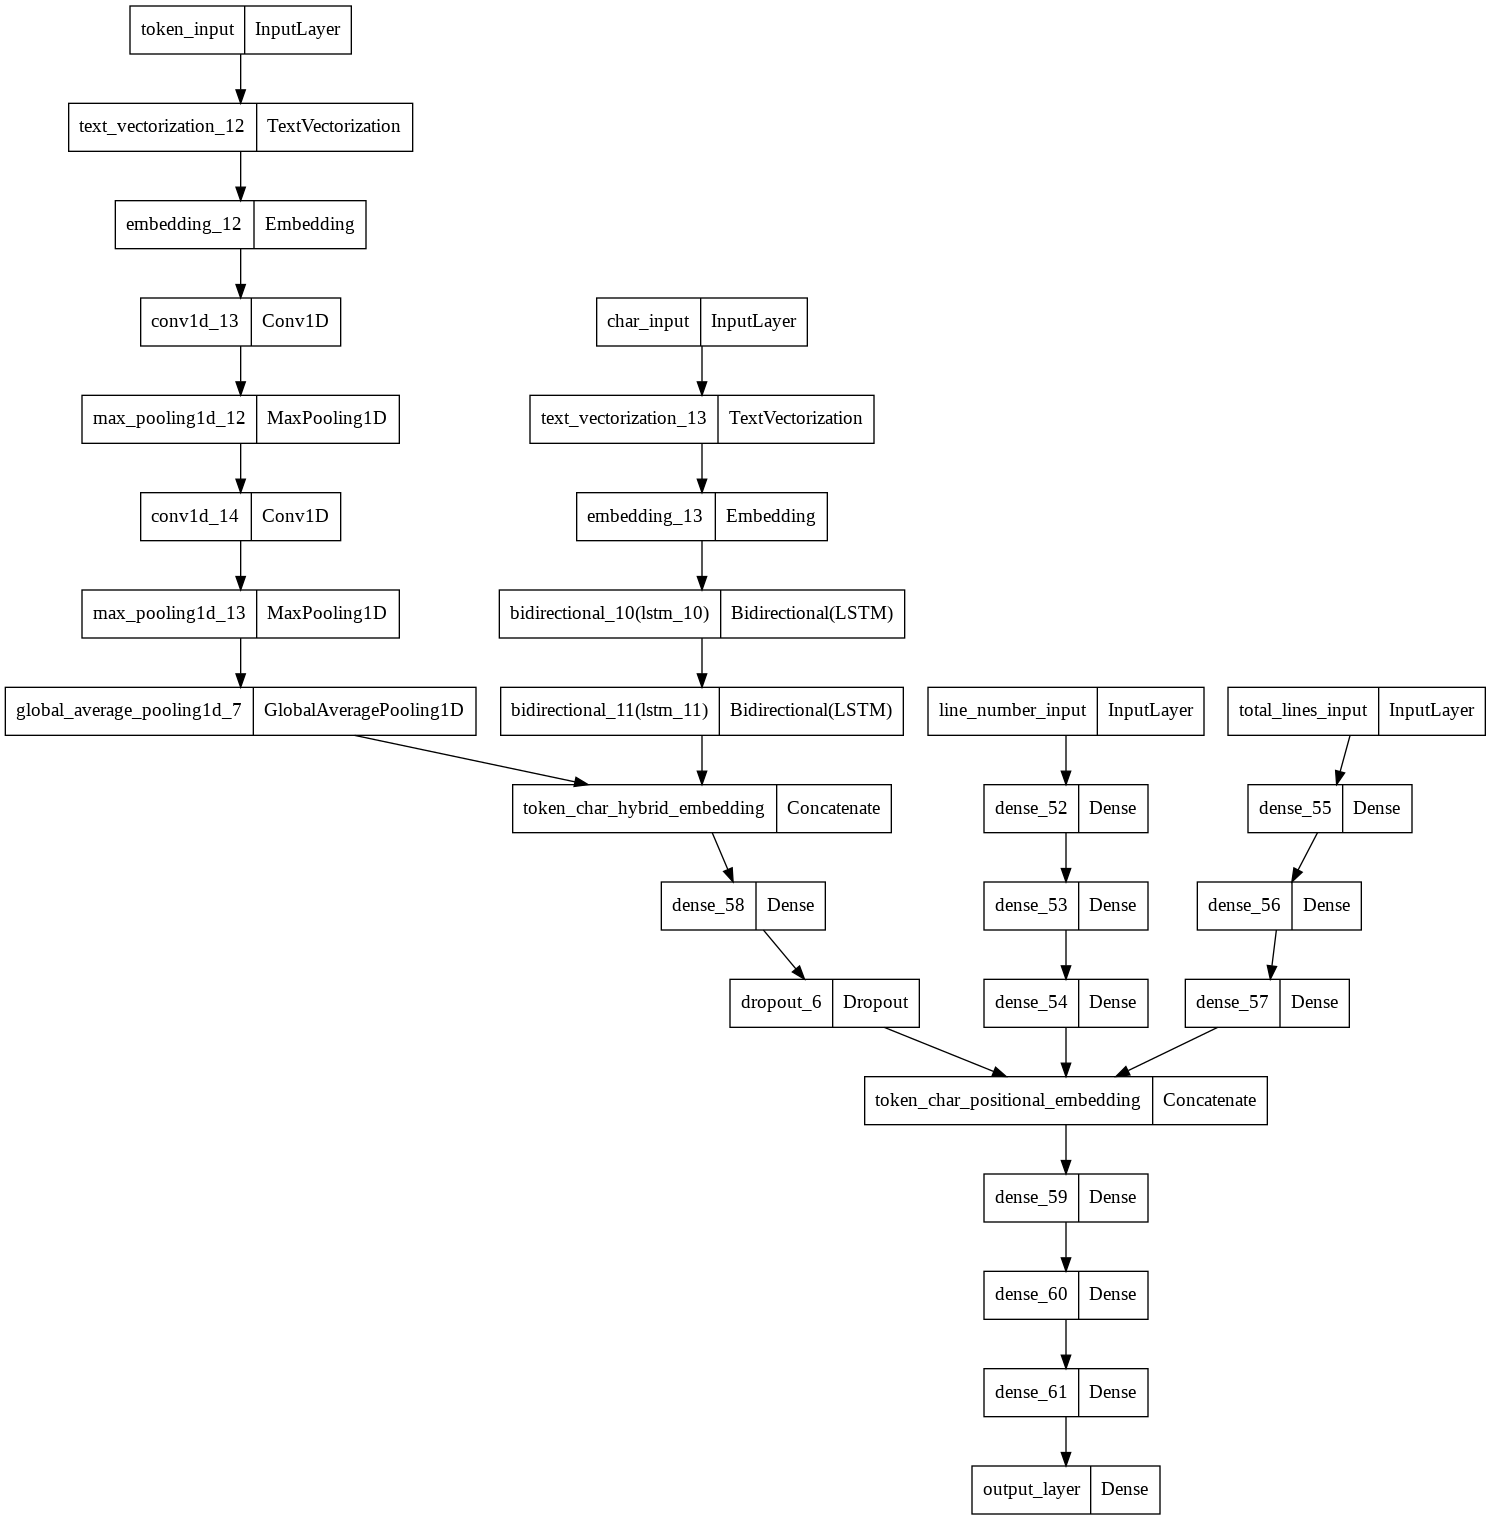

In [350]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [351]:
word_model.output

<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'global_average_pooling1d_7')>

In [352]:
char_model.output

<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'bidirectional_11')>

In [353]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_orders_one_hot, # line numbers
                                                                train_total_lines_one_hot, # total lines
                                                                X_sen_train, # train tokens
                                                                X_char_train)) # train chars
train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(y_train) # train labels
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels)) # combine data and labels
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

# Validation dataset
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_orders_one_hot,
                                                              test_total_lines_one_hot,
                                                              X_sen_test,
                                                              X_char_test))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(y_test)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) # turn into batches and prefetch appropriately

In [354]:

# Check input shapes
train_pos_char_token_dataset, test_pos_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 98), dtype=tf.float32, name=None), TensorSpec(shape=(None, 47), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.uint8, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 98), dtype=tf.float32, name=None), TensorSpec(shape=(None, 47), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.uint8, name=None))>)

In [355]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=50,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False)

lrc = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=0,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0
)

def create_chk(filename):
    chk = tf.keras.callbacks.ModelCheckpoint(
    filename,
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
    options=None,
    initial_value_threshold=None)
    return chk

In [359]:
model_5.compile(loss="categorical_crossentropy",optimizer='rmsprop', metrics=["accuracy"])

In [360]:
model_5_history = model_5.fit(train_pos_char_token_dataset, validation_data=test_pos_char_token_dataset, epochs=50)

Epoch 1/50
108/108 [==============================] - 107s 665ms/step - loss: 0.0672 - accuracy: 0.9858 - val_loss: 0.8195 - val_accuracy: 0.8566
Epoch 2/50
108/108 [==============================] - 69s 637ms/step - loss: 0.0351 - accuracy: 0.9904 - val_loss: 1.0241 - val_accuracy: 0.8552
Epoch 3/50
108/108 [==============================] - 70s 653ms/step - loss: 0.0257 - accuracy: 0.9919 - val_loss: 0.9691 - val_accuracy: 0.8559
Epoch 4/50
108/108 [==============================] - 70s 652ms/step - loss: 0.0182 - accuracy: 0.9948 - val_loss: 1.2252 - val_accuracy: 0.8498
Epoch 5/50
108/108 [==============================] - 70s 652ms/step - loss: 0.0225 - accuracy: 0.9962 - val_loss: 1.7399 - val_accuracy: 0.8376
Epoch 6/50
108/108 [==============================] - 71s 655ms/step - loss: 0.0211 - accuracy: 0.9930 - val_loss: 1.2926 - val_accuracy: 0.8505
Epoch 7/50
108/108 [==============================] - 70s 653ms/step - loss: 0.0198 - accuracy: 0.9951 - val_loss: 1.4347 - val_a

KeyboardInterrupt: ignored